# Predicción de la tasa de anillamiento de aves
**Autor:** DANIELLE MAREE MCKENNEY

In [4]:
#Importación de librerias

%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1.Lectura del dataset

### 1.1 Definición de funciones auxiliares

In [43]:
# definimos una función para quedarnos solo con las columnas relevantes para nuestro análisis
def cleanRawData(rawData, relevantColumns):
    # returns a dataframe with only the relevent columns and with invalid location entries removed
    df = rawData.filter(items=relevantColumns)
    return df

# definimos una función para llenar los valores faltantes 
def fillInCounts0(data, dateCombination):
    # Fill in count=0 in the grouped summary
    # Get all unique combinations of the date combination
    existing_combinations = data[dateCombination].drop_duplicates()

    # Create a DataFrame with all unique species
    all_species_combinations = pd.DataFrame({'NombreEspecie': data['NombreEspecie'].unique()})

    # Cross join (cartesian product) to get all combinations of 'species', 'eventDate', and 'locality'
    all_combinations = pd.merge(existing_combinations.assign(key=1), all_species_combinations.assign(key=1), on='key').drop('key', axis=1)

    # Merge with the original DataFrame to get counts
    on = dateCombination.append('NombreEspecie')
    result_df = pd.merge(all_combinations, data, on=on, how='left').fillna(0)
    return result_df

### 1.2 Tratamiento Dataset 
Después de leer el conjunto de datos, lo filtramos para quedarnos con las columnas relevantes. Las demás incluyen datos redundantes, como información sobre la taxonomía de las especies o detalles sobre la base de datos. 
Podemos observar, por ejemplo, que no hay datos faltantes y que hay una gran cantidad de localidades diferentes utilizadas en este conjunto de datos.
Dado que cada fila corresponde a un ave anillada, tendremos que remodelar estos datos para poder extraer una tasa para una localidad dada.

In [8]:
DATOS = pd.read_csv('./../limpieza/limpio/anillamiento.csv', on_bad_lines="warn")

/var/folders/dx/9xjdddhn30jfw1p92r0hl5gh0000gn/T/ipykernel_28748/736703208.py:1: DtypeWarning: Columns (0,4,6,7,10,11,12,13,14,15,16,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  DATOS = pd.read_csv('./../limpieza/limpio/anillamiento.csv', on_bad_lines="warn")


,CodigoAnillador,NombreAnillador,Anilla,NombreEspecie,CodigoEspecie,FechaCaptura,CodigoEdad,CodigoSexo,NombreLocalidad,MUNICIPIO,...,CodigoHabitat,CodigoMetodo,NumRedes,HoraCaptura,HoraDesde,HoraHasta,TipoRegistro,CodigoCentro,CodigoReclamo,DataFrameName
0,660019,MANUEL VAZQUEZ CASTRO,1006429,Phoenicopterus ruber,01470,2004-07-08,8.0,2,Fuente de Piedra,Fuente de Piedra,...,F3,S,NaN,NaN,00:00,00:00,A,ESI,U,d04
1,660019,MANUEL VAZQUEZ CASTRO,1006430,Phoenicopterus ruber,01470,2004-07-09,8.0,1,Fuente de Piedra,Fuente de Piedra,...,F3,S,NaN,NaN,00:00,00:00,A,ESI,U,d04
2,660019,MANUEL VAZQUEZ CASTRO,1006440,Phoenicopterus ruber,01470,2004-07-12,8.0,2,Fuente de Piedra,Fuente de Piedra,...,F3,S,NaN,NaN,00:00,00:00,A,ESI,U,d04
3,630038,José Manuel Sayago Robles,1008842,Bubo bubo,07440,2004-03-06,1.0,0,Puebla de Guzman,Puebla de Guzman,...,H1,M,NaN,NaN,00:00,00:00,A,ESI,U,d04
4,630038,José Manuel Sayago Robles,1008843,Bubo bubo,07440,2004-03-06,1.0,0,Puebla de Guzman,Puebla de Guzman,...,H1,H,NaN,NaN,00:00,00:00,A,ESI,U,d04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255127,660019,MANUEL VAZQUEZ CASTRO,NX05627,Aythya nyroca,NaN,2018-12-17,3,2,CAÑADA DE LOS PAJAROS,LA PUEBLA DEL RIO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Manolo
255128,660019,MANUEL VAZQUEZ CASTRO,NX05628,Aythya nyroca,NaN,2018-12-17,3,1,CAÑADA DE LOS PAJAROS,LA PUEBLA DEL RIO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Manolo
255129,660019,MANUEL VAZQUEZ CASTRO,NX05629,Aythya nyroca,NaN,2018-12-17,3,1,CAÑADA DE LOS PAJAROS,LA PUEBLA DEL RIO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Manolo
255130,660019,MANUEL VAZQUEZ CASTRO,NX05630,Aythya nyroca,NaN,2018-12-17,3,2,CAÑADA DE LOS PAJAROS,LA PUEBLA DEL RIO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Manolo


In [38]:
# Print some useful stats: 
# print(DATOS.info())
# print(DATOS.describe())
# print(DATOS.shape)
# print(DATOS.columns)


In [41]:
#Lectura del dataset y selección de las columnas relevantes
relevantColumns = ['NombreEspecie','FechaCaptura','NombreLocalidad']
df = cleanRawData(DATOS, relevantColumns)
# Sanity check on dates
df = df[df['FechaCaptura'].str[:2].isin(['19', '20'])]
# Convert date column to date type
df['FechaCaptura'] = pd.to_datetime(df['FechaCaptura'])

localities = DATOS['NombreLocalidad'].value_counts()
loc1 = localities.index[0]

mostCommonBird = DATOS[DATOS['NombreLocalidad'] == loc1]
birds = DATOS['NombreEspecie'].value_counts()
bird1 = birds.index[0]
birds


NombreEspecie
Acrocephalus scirpaceus    29253
Phylloscopus collybita     22007
Hirundo rustica            18381
Sylvia atricapilla         14808
Passer domesticus          13645
                           ...  
Lymnocriptes minimus           1
Tachibaptus ruficollis         1
Calandrella rusfescens         1
Lonchura punctulata            1
Phoenicopterus roseus          1
Name: count, Length: 403, dtype: int64

## 2.Agrupaciones del dataset

### 2.1 Agrupaciones

Los datos de anillamiento de aves no se recopilaron todos los días, por lo que, con el fin de tener datos suficientes para crear una serie temporal, necesitamos agrupar las observaciones.

In [44]:

# Group and count the rows in each group
grouped_eventDate_df = df.groupby(['NombreEspecie', 'FechaCaptura', 'NombreLocalidad']).size().reset_index(name='count')
# Fill in count=0 on days where a locality was visited but no entry was made for that species
grouped_eventDate_df = fillInCounts0(grouped_eventDate_df, ['FechaCaptura', 'NombreLocalidad'])

grouped_eventDate_df['month'] = grouped_eventDate_df['FechaCaptura'].dt.month
grouped_eventDate_df['year'] = grouped_eventDate_df['FechaCaptura'].dt.year

grouped_month_df = grouped_eventDate_df.groupby(['NombreEspecie', 'month', 'year', 'NombreLocalidad']).sum('count').reset_index()
grouped_month_df = grouped_month_df.filter(items=['NombreEspecie', 'month', 'year', 'NombreLocalidad', 'count'])

grouped_year_df = grouped_eventDate_df.groupby(['NombreEspecie', 'year', 'NombreLocalidad']).sum('count').reset_index()
grouped_year_df = grouped_year_df.filter(items=['NombreEspecie', 'year', 'NombreLocalidad', 'count'])

### 2.2. Conteo de especies por año

Con visualizaciones, podemos observar que ciertas especies, ciertas ubicaciones y ciertos años tienen más datos disponibles. Utilizaremos esta información para tomar decisiones sobre qué tipo de ave y para qué ubicación crearemos un modelo de series temporales.

In [ ]:
# Crear una paleta de colores única basada en todas las especies
paleta_colores = sns.color_palette('husl', n_colors=len(grouped_year_df['NombreEspecie'].unique()))
# Mapear cada especie a un color específico
especies_a_colores = dict(zip(grouped_year_df['NombreEspecie'].unique(), paleta_colores))

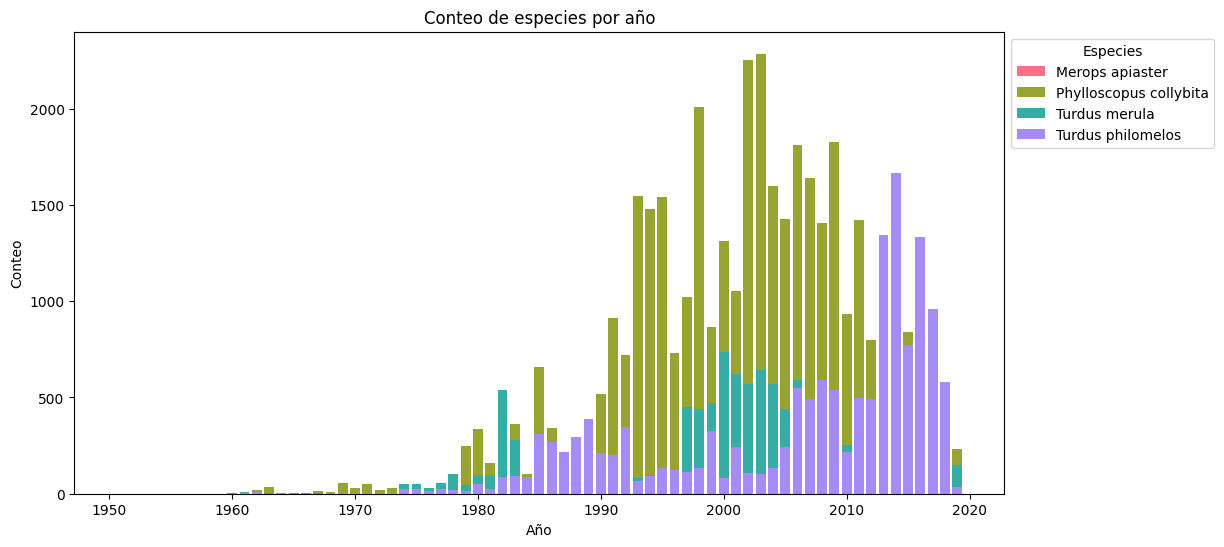

In [10]:
### 2.1. Conteo de especies por año

# Conteo de especies por año
plt.figure(figsize=(12, 6))
for species, data in grouped_year_df.groupby('species'):
    plt.bar(data['year'], data['count'], label=species, color=especies_a_colores[species])
plt.xlabel('Año')
plt.ylabel('Conteo')
plt.title('Conteo de especies por año')
plt.legend(title='Especies', bbox_to_anchor=(1, 1))
plt.show()

### 2.3. Estacionalidad - Conteo de especies por meses

Con la siguiente visualización, observamos que ciertas especies solo están presentes en ciertos momentos del año en España. Esto significa que nuestra serie temporal tendrá un componente estacional anual.


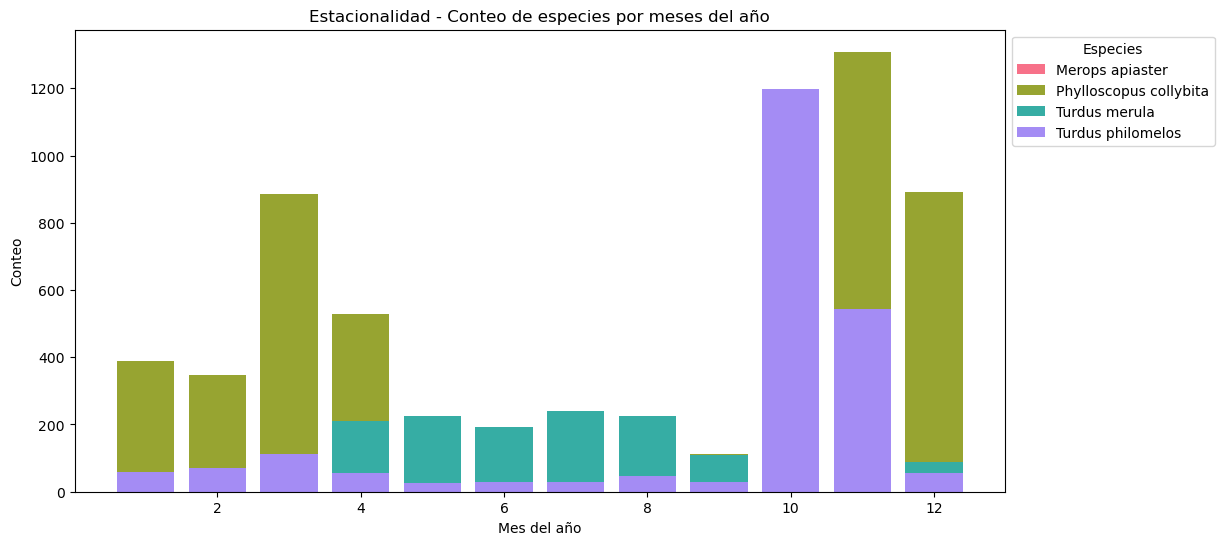

In [10]:
### 2.3. Estacionalidad - Conteo de especies por meses
plt.figure(figsize=(12, 6))
for species, data in grouped_month_df.groupby('species'):
    plt.bar(data['month'], data['count'], label=species, color=especies_a_colores[species])
plt.xlabel('Mes del año')
plt.ylabel('Conteo')
plt.title('Estacionalidad - Conteo de especies por meses del año')
plt.legend(title='Especies', bbox_to_anchor=(1, 1))
plt.show()

## 3. Selección de la Localidad

Just because a certain location contains a lot of entries, doesn't mean it will be a good candidate for doing a time series prediction. We want a location to contain a entries for a lot of months, over a long period of time. Based on this criteria, the 1st and 3rd most commonly occurring localities are good candidates.

/var/folders/dx/9xjdddhn30jfw1p92r0hl5gh0000gn/T/ipykernel_28748/1198329411.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_month_df_top_loc['date'] = pd.to_datetime(grouped_month_df_top_loc[['year', 'month']].assign(DAY=1))


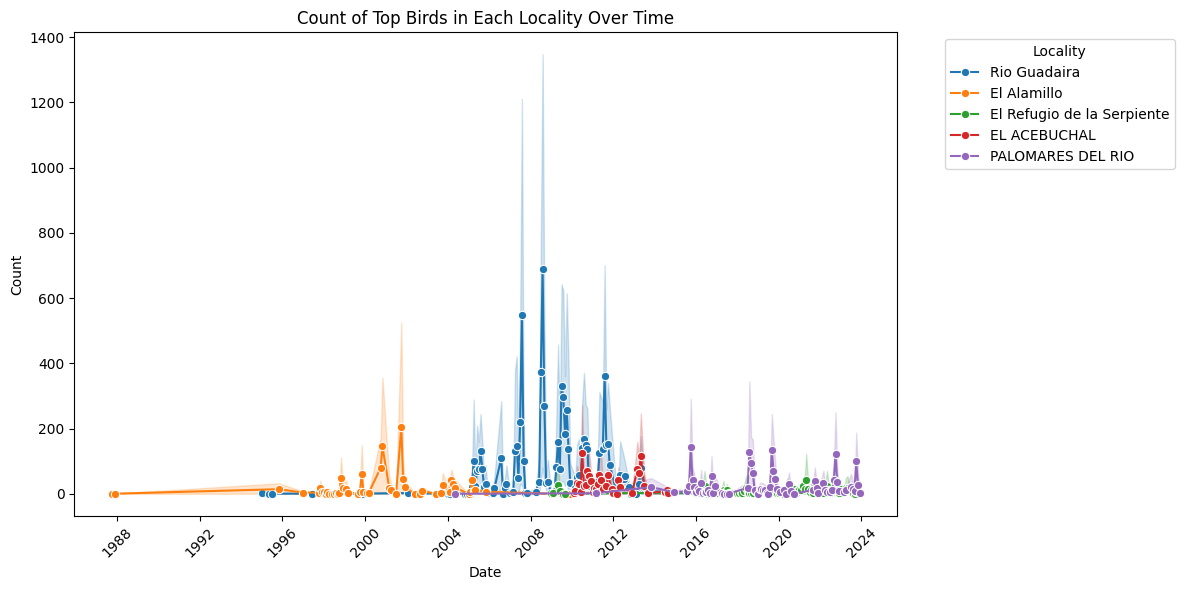

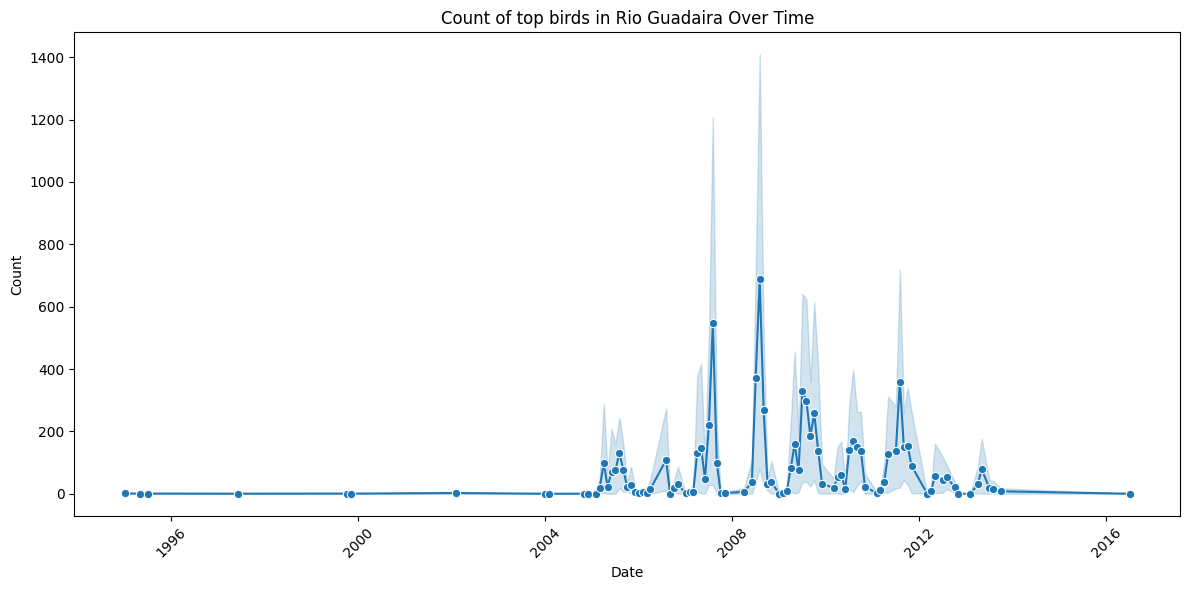

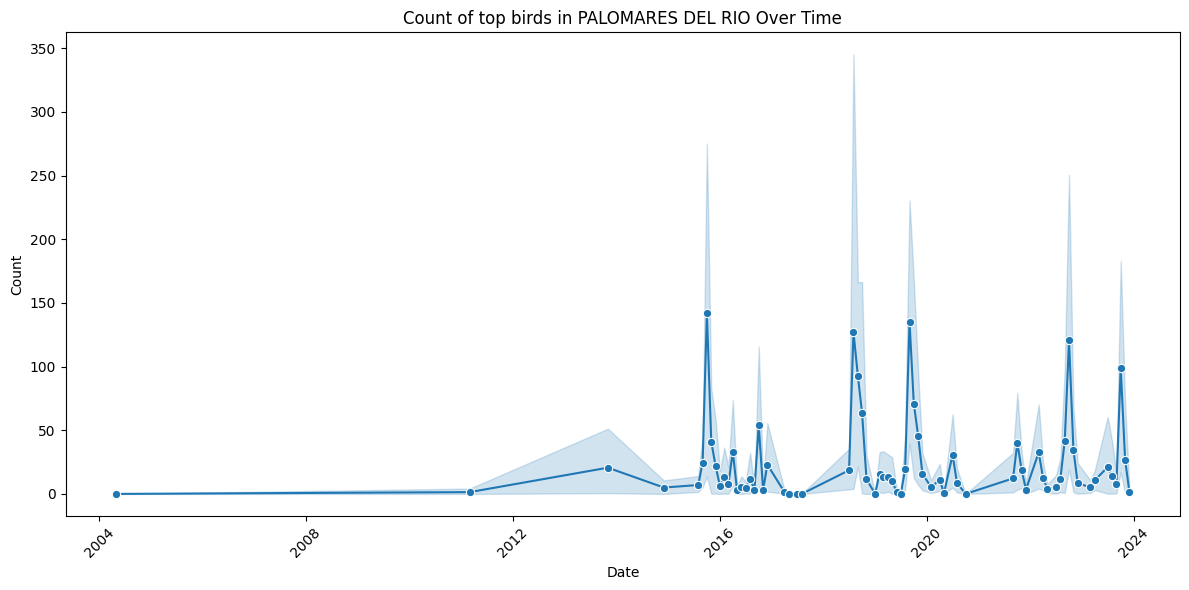

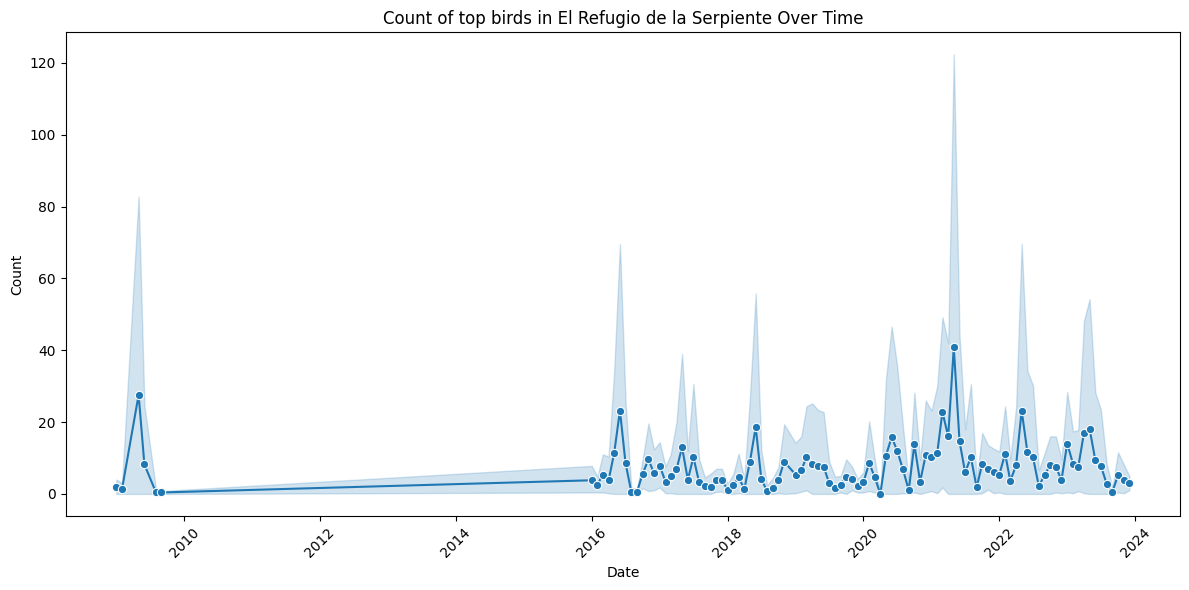

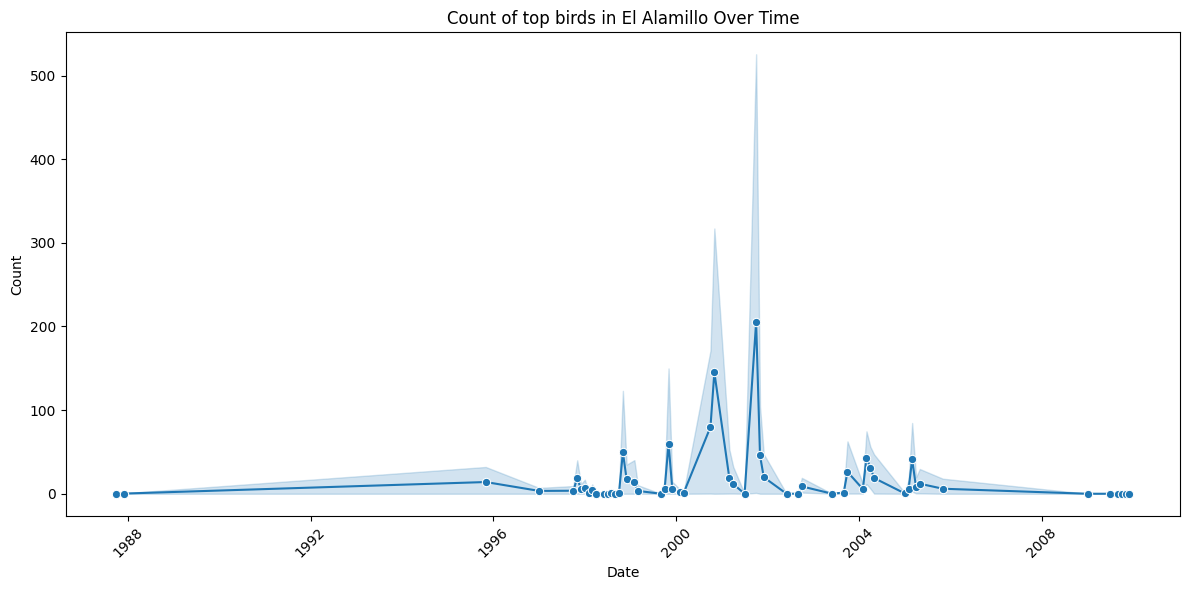

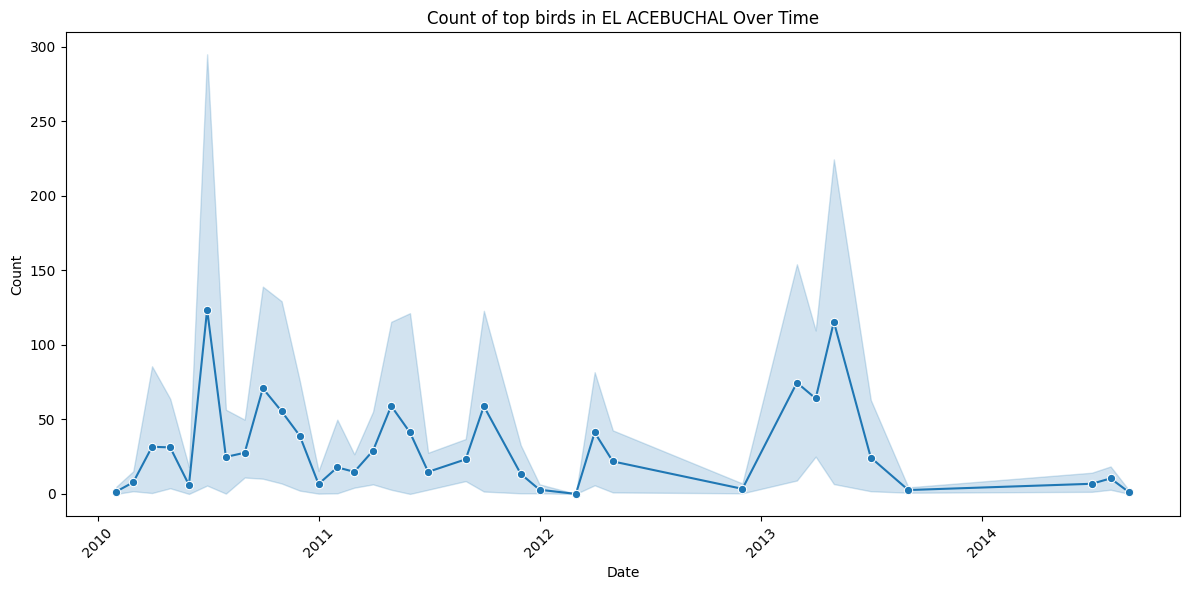

Locality with the most data: Rio Guadaira


In [83]:
# Show when the top 5 birds are caught in the top 5 localities to decide which ones to use for a time series

# Get the 5 most common localities
top_localities = localities.nlargest(5)

# List the names and counts of the top localities
grouped_month_df_top_loc = grouped_month_df[grouped_month_df['NombreLocalidad'].isin(top_localities.index)]
grouped_month_df_top_loc['date'] = pd.to_datetime(grouped_month_df_top_loc[['year', 'month']].assign(DAY=1))
top_birds = grouped_month_df_top_loc.groupby('NombreEspecie')['count'].sum().nlargest(5)
# top_birds = grouped_month_df_top_loc['NombreEspecie'].value_counts().nlargest(10)

# Filter data for the selected species
species_data = grouped_month_df_top_loc[grouped_month_df_top_loc['NombreEspecie'].isin(top_birds.index.tolist())]

# Plot the count in each location over time
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='count', hue='NombreLocalidad', data=species_data, marker='o')
plt.title(f'Count of Top Birds in Each Locality Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Locality', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

for cld in top_localities.index:
    chosen_locality_data = species_data[species_data['NombreLocalidad'] == cld]

    # Plot the count for the chosen locality
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='date', y='count', data=chosen_locality_data, marker='o')
    plt.title(f'Count of top birds in {cld} Over Time')
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

print(f"Locality with the most data: {top_localities.idxmax()}")
max_locality = top_localities.idxmax()

Again, to select which bird is the best candidate for the time series, we are not interested in the bird that was simply caught most frequently in these localities. We want a bird that is consistently being caught each year.

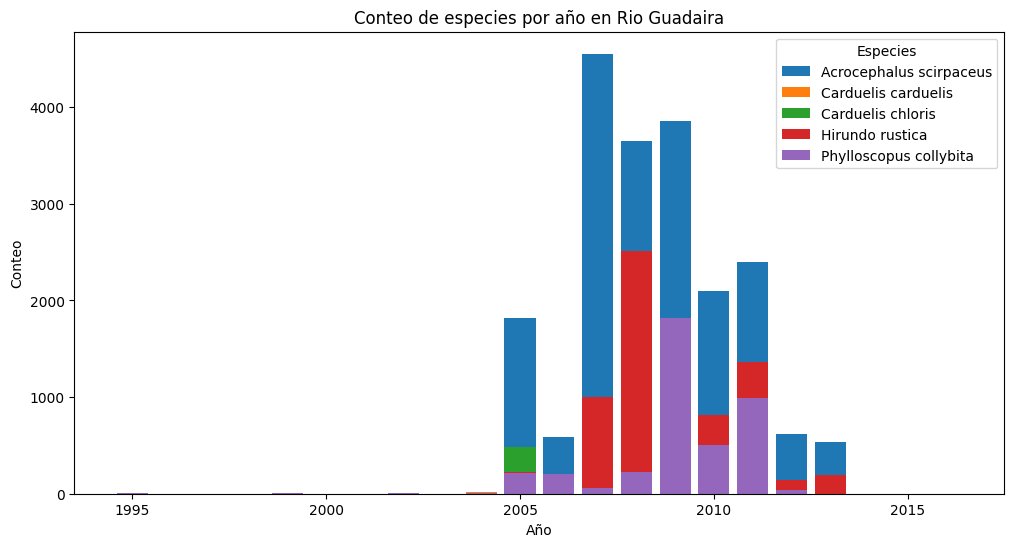

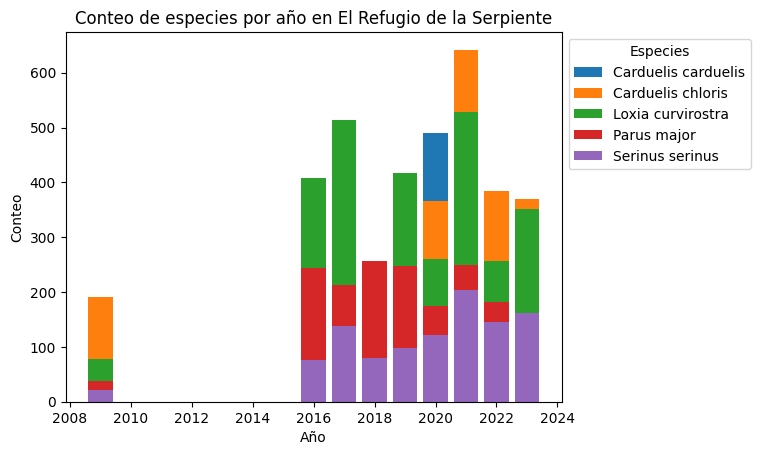

In [137]:
# Conteo de especies por año
plt.figure(figsize=(12, 6))
top_birds = grouped_year_df[grouped_year_df['NombreLocalidad']==loc1].groupby('NombreEspecie')['count'].sum().nlargest(5)
loc1Birds = grouped_year_df[(grouped_year_df['NombreLocalidad']==loc1) & (grouped_year_df['NombreEspecie'].isin(top_birds.index.tolist()))]
for species, data in loc1Birds.groupby('NombreEspecie'):
    plt.bar(data['year'], data['count'], label=species)
plt.xlabel('Año')
plt.ylabel('Conteo')
plt.title(f"Conteo de especies por año en {loc1}")
plt.legend(title='Especies', bbox_to_anchor=(1, 1))
plt.show()

loc3= localities.index[2]
top_birds = grouped_year_df[grouped_year_df['NombreLocalidad']==loc3].groupby('NombreEspecie')['count'].sum().nlargest(5)
loc3Birds = grouped_year_df[(grouped_year_df['NombreLocalidad']==loc3) & (grouped_year_df['NombreEspecie'].isin(top_birds.index.tolist()))]
for species, data in loc3Birds.groupby('NombreEspecie'):
    plt.bar(data['year'], data['count'], label=species)
plt.xlabel('Año')
plt.ylabel('Conteo')
plt.title(f"Conteo de especies por año en {loc3}")
plt.legend(title='Especies', bbox_to_anchor=(1, 1))
plt.show()

## 4.Predicción series temporales

Debido a que las series temporales no pueden manejar predicciones espacio-temporales, seleccionamos una especie y una ubicación para modelar. Para seleccionar la ubicación, queremos asegurarnos de que tenga una buena cantidad de datos a lo largo de varios años. La siguiente visualización nos ayuda con esta decisión.

### 4.1. Optimización de parámetros

### 4.2. Definición del modelo
Crearemos un modelo para el mosquitero común localidad en la localidad Parque el alamillo. El conjunto de datos siguiente es lo que alimentaremos en nuestro modelo:

/var/folders/dx/9xjdddhn30jfw1p92r0hl5gh0000gn/T/ipykernel_28748/1905538456.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['date'] = pd.to_datetime(grouped_month_df_mean[['year', 'month']].assign(DAY=1))


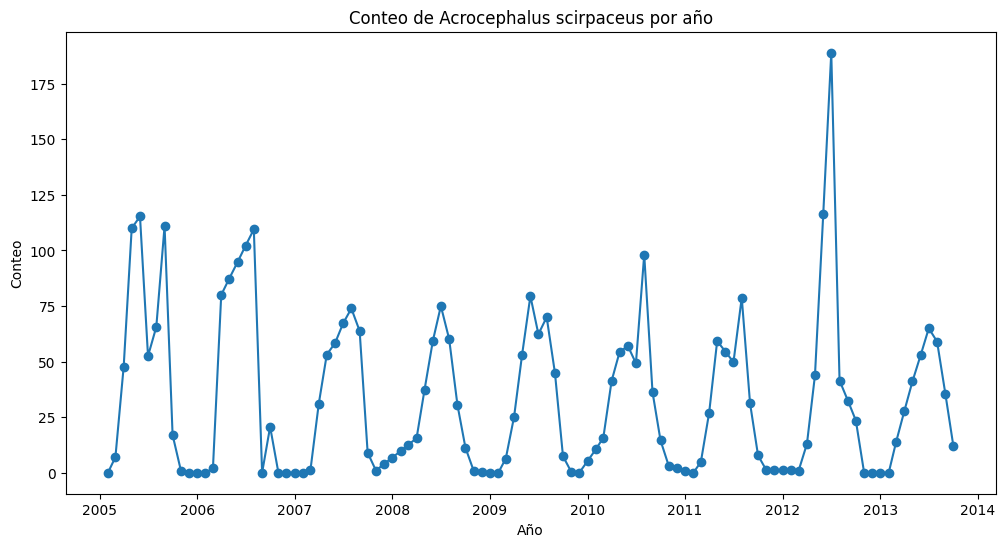

In [139]:
def defineSeries(especie, locality, desde, hasta):
    # Obtener la media promedio de anillado para esta especie en esta localidad
    grouped_month_df_mean = grouped_eventDate_df.groupby(['NombreEspecie', 'month', 'year', 'NombreLocalidad']).mean('count').reset_index()
    grouped_month_df_mean = grouped_month_df_mean.filter(items=['NombreEspecie', 'month', 'year', 'NombreLocalidad', 'count'])

    # Filtrar el DataFrame para la especie y localidad específicas
    df_filtrado = grouped_month_df_mean[(grouped_month_df_mean['NombreEspecie'] == especie) & (grouped_month_df_mean['NombreLocalidad'] == locality)]
    df_filtrado['date'] = pd.to_datetime(grouped_month_df_mean[['year', 'month']].assign(DAY=1))
    df_filtrado = df_filtrado.sort_values(by='date')
    df_filtrado = df_filtrado[(df_filtrado['date'] > desde) & (df_filtrado['date'] < hasta)]

    # Preparar los datos para el análisis de series temporales
    datos = df_filtrado.sort_values(by='date')
    datos = datos.drop(['NombreEspecie', 'NombreLocalidad'], axis=1)
    datos = datos.set_index('date')

    # Definir la frecuencia mensual
    start_date = datos.index.min()
    end_date = datos.index.max()
    new_dates = pd.date_range(start=start_date, end=end_date, freq='MS')
    new_datos = pd.DataFrame(index=new_dates)
    datos = new_datos.merge(datos, how='left', left_index=True, right_index=True)

    # Interpolar los valores faltantes por la media lineal
    datos['count'].interpolate(method='linear', limit_direction='both', inplace=True)
    return datos

def plotCountOverTime(datos, especie):
    # Visualizar la serie temporal
    plt.figure(figsize=(12, 6))
    plt.plot(datos.index, datos['count'], marker='o', label=especie)
    plt.xlabel('Año')
    plt.ylabel('Conteo')
    plt.title(f"Conteo de {especie} por año")
    plt.show()

# Especificar la especie y localidad
loc1_grouped_month_df = grouped_month_df[grouped_month_df['NombreLocalidad']==loc1]
top_birds = loc1_grouped_month_df.groupby('NombreEspecie')['count'].sum().nlargest(5)

especie = top_birds.index[0]
datos = defineSeries(especie, loc1, '2005-01-01', '2015-01-01')
plotCountOverTime(datos, especie)

### 4.3.Suavizado de datos
Podemos observar que a principios de la década de 2000 se anillaron muchas más aves que en otros años, por lo que suavizamos estos años atípicos:

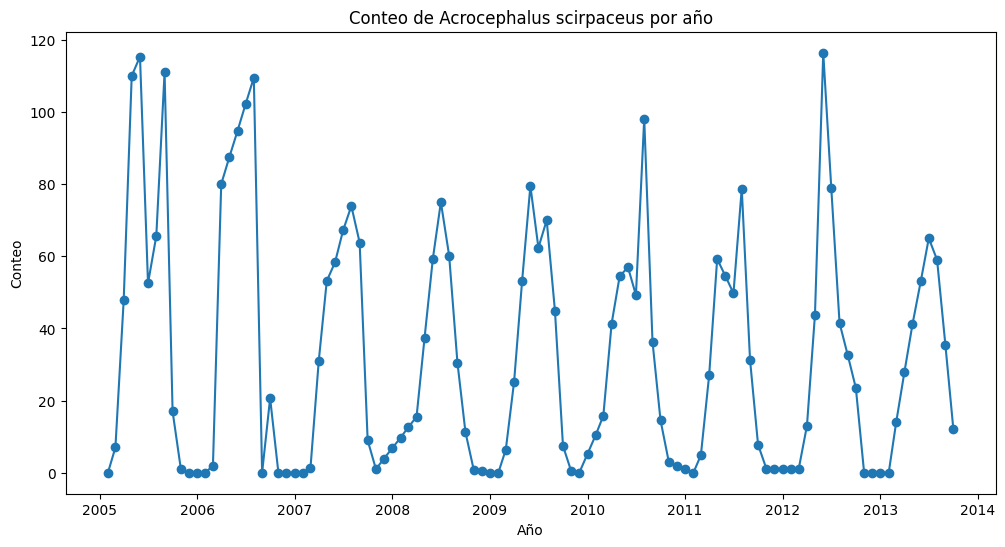

In [129]:
# Smooth the data; interpolate on data whose zscore is >= umbral_zscore
def suavizar_outliers(datos, umbral_zscore=3):
    # Crear un DataFrame para manipulación conveniente
    df = pd.DataFrame({'serie': datos})   
    
    # Calcular y almacenar los valores Z-score
    df['zscore'] = stats.zscore(datos).abs()
    
    # Establecer a NaN los valores que superan el umbral Z-score
    df.loc[df['zscore'] >= umbral_zscore, 'serie'] = np.nan
    
    # Interpolar los valores faltantes de la serie
    df['serie'] = df['serie'].interpolate(method='linear')
    
    # Devolver la serie suavizada sin outliers
    return df['serie']


datos_smoothed = datos.copy()
datos_smoothed['count'] = suavizar_outliers(datos['count'], 4)
plotCountOverTime(datos_smoothed, especie)


### Apply Time Series to the data

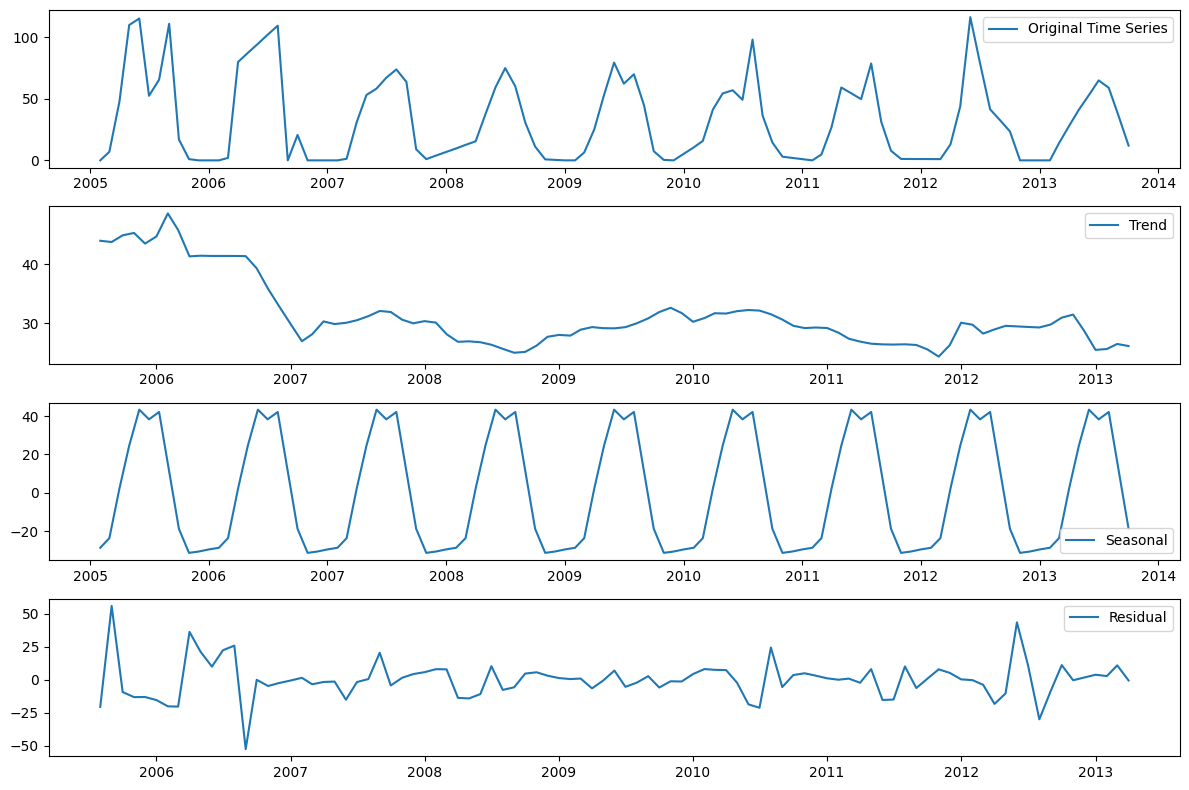

In [130]:
# Perform seasonal decomposition
def plotSeasonalDecomp(data, result):
    # Plot the original time series, trend, seasonal, and residual components
    plt.figure(figsize=(12, 8))

    plt.subplot(4, 1, 1)
    plt.plot(data['count'], label='Original Time Series')
    plt.legend()

    plt.subplot(4, 1, 2)
    plt.plot(result.trend, label='Trend')
    plt.legend()

    plt.subplot(4, 1, 3)
    plt.plot(result.seasonal, label='Seasonal')
    plt.legend()

    plt.subplot(4, 1, 4)
    plt.plot(result.resid, label='Residual')
    plt.legend()

    plt.tight_layout()
    plt.show()

result = seasonal_decompose(datos_smoothed['count'], model='additive', period=12)
plotSeasonalDecomp(datos_smoothed, result)

### 4.3. Selección de Hyperparámetros
Utilizamos los gráficos de autocorrelación y autocorrelación parcial para determinar el intervalo de parámetros que debemos introducir en un GridSearch. Los picos en el PACF indican valores p potencialmente buenos (orden de autoregresión) y los picos en el ACF indican valores q potencialmente buenos (orden de media móvil). Sin embargo, debido a la limitación de los recursos informáticos, la búsqueda fue limitada.

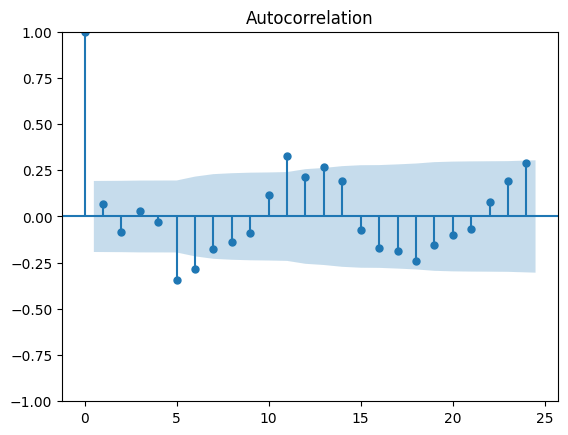

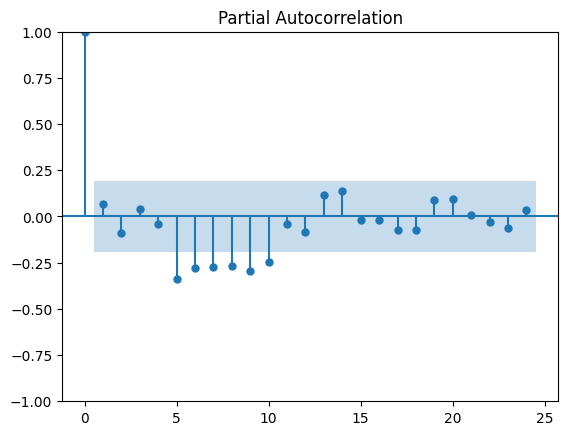

In [131]:
# With one order of differencing
diff = datos_smoothed['count'].diff().dropna()
plot_pacf(diff, lags=24)
plot_acf(diff, lags=24)
plt.show()

In [119]:
%%capture
# optimizacion de parámetros

# Parámetros a probar
# p_values = [0, 1, 5]
# d_values = [0, 1, 2]
# q_values = [1, 6, 12]
# P_values = [0, 1, 5]
# D_values = [1]
# Q_values = [1, 6 ,12]


def gridSearch(p_values, d_values, q_values, P_values, D_values, Q_values, data)
    # Almacena los resultados y los criterios de evaluación
    best_aic = np.inf
    best_order = None
    best_seasonal_order = None

    # Grid Search
    # Itera sobre todas las combinaciones posibles
    for p, d, q, P, D, Q in product(p_values, d_values, q_values, P_values, D_values, Q_values):
        try:
            # Ajusta el modelo SARIMA
            order = (p, d, q)
            seasonal_order = (P, D, Q, 12)  # La estacionalidad asumida es anual
            sarima_model = SARIMAX(data['count'], order=order, seasonal_order=seasonal_order)
            sarima_results = sarima_model.fit()

            # Almacena el modelo si mejora el criterio de evaluación (menor AIC en este caso)
            if sarima_results.aic < best_aic:
                best_aic = sarima_results.aic
                best_order = order
                best_seasonal_order = seasonal_order

        except Exception as e:
            continue
    return best_order, best_seasonal_order, best_aic

p_values = [0, 1]
d_values = [1, 2]
q_values = [1, 6]
P_values = [0, 1]
D_values = [1]
Q_values = [1, 6]
best_order, best_seasonal_order, best_aic = gridSearch(p_values, d_values, q_values, P_values, D_values, Q_values)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.96041D+00    |proj g|=  4.93744D-02

At iterate    5    f=  3.84848D+00    |proj g|=  2.08209D-02

At iterate   10    f=  3.84392D+00    |proj g|=  3.38998D-04

At iterate   15    f=  3.84075D+00    |proj g|=  1.28801D-04

At iterate   20    f=  3.84074D+00    |proj g|=  3.09170D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     33      1     0     0   4.931D-06   3.841D+00
  F =   3.8407153001032079     

CONVERG

/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.07993D+00    |proj g|=  3.23667D-01

At iterate    5    f=  3.91926D+00    |proj g|=  1.62426D-02

At iterate   10    f=  3.83331D+00    |proj g|=  1.96574D-02

At iterate   15    f=  3.83104D+00    |proj g|=  2.01102D-03

At iterate   20    f=  3.83091D+00    |proj g|=  8.53819D-04

At iterate   25    f=  3.83090D+00    |proj g|=  2.92116D-04

At iterate   30    f=  3.83086D+00    |proj g|=  3.01220D-03

At iterate   35    f=  3.82997D+00    |proj g|=  5.26185D-02

At iterate   40    f=  3.82345D+00    |proj g|=  2.35591D-03

At iterate   45    f=  3.82329D+00    |proj g|=  3.10770D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate   20    f=  3.83746D+00    |proj g|=  2.76563D-03

At iterate   25    f=  3.83719D+00    |proj g|=  3.84301D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     46      1     0     0   3.843D-06   3.837D+00
  F =   3.8371860348362654     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.07993D+00    |proj g|=  3.23667D-01

At iterate    5    f=  3.93584D+00    |proj g|=  2.14985D-02

At iterate   10    f=  3.83759D+00    |proj g|=  4.55447D-02

At iterate   15    f=  3.83204D+00    |proj g|=  1.12338D-03

At iterate   20    f=  3.83199D+00    |proj g|=  5.48621D-04

At iterate   25    f=  3.83189D+00    |proj g|=  2.65573D-03

At iterate   30    f=  3.83144D+00    |proj g|=  2.75543D-03

At iterate   35    f=  3.83120D+00    |proj g|=  4.38554D-03

At iterate   40    f=  3.83109D+00    |proj g|=  4.78133D-04

At iterate   45    f=  3.83102D+00    |proj g|=  1.66743D-03

At iterate   50    f=  3.83094D+00    |proj g|=  9.34243D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.25482D+00    |proj g|=  6.15865D-01

At iterate    5    f=  3.82798D+00    |proj g|=  7.31585D-02

At iterate   10    f=  3.79432D+00    |proj g|=  9.19304D-03

At iterate   15    f=  3.79347D+00    |proj g|=  7.09936D-03

At iterate   20    f=  3.79269D+00    |proj g|=  2.29001D-03

At iterate   25    f=  3.79213D+00    |proj g|=  2.87248D-03

At iterate   30    f=  3.79198D+00    |proj g|=  1.04520D-03

At iterate   35    f=  3.79195D+00    |proj g|=  3.71049D-04

At iterate   40    f=  3.79195D+00    |proj g|=  1.32796D-04

At iterate   45    f=  3.79195D+00    |proj g|=  2.06893D-04


/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



At iterate   50    f=  3.79195D+00    |proj g|=  9.12088D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     54      1     0     0   9.121D-05   3.792D+00
  F =   3.7919453016419329     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.87818D+00    |proj g|=  1.35064D+00

At iterate    5    f=  3.80285D+00    |proj g|=  7.24484D-02

At iterate   10    f=  3.77676D+00    |proj g|=  9.36834D-03

At iterate   15    f=  3.77482D+00    |proj g|=  3.87720D-03

At iterate   20    f=  3.77302D+00    |proj g|=  1.70327D-02

At iterate   25    f=  3.77267D+00    |proj g|=  8.01266D-04

At iterate   30    f=  3.77264D+00    |proj g|=  5.61673D-04

At iterate   35    f=  3.77264D+00    |proj g|=  2.12438D-04

At iterate   40    f=  3.77264D+00    |proj g|=  5.30818D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.28620D+00    |proj g|=  6.39965D-01

At iterate    5    f=  3.80166D+00    |proj g|=  3.41952D-02

At iterate   10    f=  3.78732D+00    |proj g|=  3.58123D-03

At iterate   15    f=  3.78674D+00    |proj g|=  9.23264D-03

At iterate   20    f=  3.78631D+00    |proj g|=  4.90841D-03

At iterate   25    f=  3.78624D+00    |proj g|=  1.10393D-04

At iterate   30    f=  3.78624D+00    |proj g|=  8.72453D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.87818D+00    |proj g|=  1.35064D+00

At iterate    5    f=  3.79377D+00    |proj g|=  3.97118D-02

At iterate   10    f=  3.77564D+00    |proj g|=  4.81215D-03

At iterate   15    f=  3.77414D+00    |proj g|=  8.86822D-03

At iterate   20    f=  3.77292D+00    |proj g|=  9.21289D-04

At iterate   25    f=  3.77288D+00    |proj g|=  6.60725D-04

At iterate   30    f=  3.77285D+00    |proj g|=  1.59532D-03

At iterate   35    f=  3.77278D+00    |proj g|=  1.58710D-03

At iterate   40    f=  3.77273D+00    |proj g|=  1.03255D-03

At iterate   45    f=  3.77271D+00    |proj g|=  1.05359D-03


/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.77266D+00    |proj g|=  1.60761D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     52      1     0     0   1.608D-03   3.773D+00
  F =   3.7726610281835105     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.64686D+00    |proj g|=  8.36046D-01

At iterate    5    f=  4.12890D+00    |proj g|=  1.03861D-02

At iterate   10    f=  4.05605D+00    |proj g|=  7.99067D-04

At iterate   15    f=  4.05535D+00    |proj g|=  7.93342D-05

At iterate   20    f=  4.05519D+00    |proj g|=  4.54190D-05

At iterate   25    f=  4.05518D+00    |proj g|=  1.53230D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     31      1     0     0   

/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f=  4.11844D+00    |proj g|=  3.86007D-02

At iterate   10    f=  4.06588D+00    |proj g|=  1.24384D-02

At iterate   15    f=  3.99401D+00    |proj g|=  2.01721D-03

At iterate   20    f=  3.99359D+00    |proj g|=  2.95560D-03

At iterate   25    f=  3.99332D+00    |proj g|=  6.19058D-04

At iterate   30    f=  3.99328D+00    |proj g|=  1.57932D-03

At iterate   35    f=  3.99325D+00    |proj g|=  9.12943D-04

At iterate   40    f=  3.99325D+00    |proj g|=  4.33369D-04

At iterate   45    f=  3.99324D+00    |proj g|=  4.86154D-04


/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.99324D+00    |proj g|=  3.24499D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     57      1     0     0   3.245D-04   3.993D+00
  F =   3.9932383269457685     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.64941D+00    |proj g|=  8.30829D-01

At iterate    5    f=  4.11984D+00    |proj g|=  1.21448D-02

At iterate   10    f=  4.03211D+00    |proj g|=  1.88816D-02

At iterate   15    f=  4.02947D+00    |proj g|=  9.15900D-04

At iterate   20    f=  4.02938D+00    |proj g|=  8.06213D-05

At iterate   25    f=  4.02938D+00    |proj g|=  1.16831D-04

At iterate   30    f=  4.02935D+00    |proj g|=  6.49173D-05

At iterate   35    f=  4.02934D+00    |proj g|=  4.89394D-05

At iterate   40    f=  4.02933D+00    |proj g|=  5.11684D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.01049D+00    |proj g|=  1.25906D+00

At iterate    5    f=  4.12020D+00    |proj g|=  5.60215D-02

At iterate   10    f=  4.03968D+00    |proj g|=  1.17310D-01

At iterate   15    f=  3.99451D+00    |proj g|=  6.91537D-03

At iterate   20    f=  3.99377D+00    |proj g|=  5.57555D-03

At iterate   25    f=  3.99351D+00    |proj g|=  3.15494D-03

At iterate   30    f=  3.99347D+00    |proj g|=  4.28131D-03

At iterate   35    f=  3.99345D+00    |proj g|=  1.50398D-04

At iterate   40    f=  3.99344D+00    |proj g|=  8.18756D-04

At iterate   45    f=  3.99342D+00    |proj g|=  5.70169D-04


/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.99340D+00    |proj g|=  8.54941D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     55      1     0     0   8.549D-04   3.993D+00
  F =   3.9933977258781108     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.09238D+00    |proj g|=  1.56933D+00

At iterate    5    f=  3.98841D+00    |proj g|=  1.64875D-01

At iterate   10    f=  3.88194D+00    |proj g|=  2.01694D-02

At iterate   15    f=  3.82991D+00    |proj g|=  6.22776D-02

At iterate   20    f=  3.81667D+00    |proj g|=  5.19992D-03

At iterate   25    f=  3.81478D+00    |proj g|=  1.33294D-03

At iterate   30    f=  3.81366D+00    |proj g|=  2.38975D-03

At iterate   35    f=  3.81281D+00    |proj g|=  2.07526D-03

At iterate   40    f=  3.81258D+00    |proj g|=  1.37703D-03

At iterate   45    f=  3.81254D+00    |proj g|=  5.47524D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.78572D+00    |proj g|=  2.36336D+00


 This problem is unconstrained.



At iterate    5    f=  3.98529D+00    |proj g|=  6.49811D-02

At iterate   10    f=  3.87504D+00    |proj g|=  1.75149D-02

At iterate   15    f=  3.82807D+00    |proj g|=  5.37569D-02

At iterate   20    f=  3.79550D+00    |proj g|=  1.99776D-02

At iterate   25    f=  3.79449D+00    |proj g|=  2.41653D-03

At iterate   30    f=  3.79434D+00    |proj g|=  4.37402D-03

At iterate   35    f=  3.79423D+00    |proj g|=  7.45415D-04

At iterate   40    f=  3.79416D+00    |proj g|=  1.03587D-03

At iterate   45    f=  3.79413D+00    |proj g|=  5.49869D-04


/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.79409D+00    |proj g|=  9.43636D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     53      1     0     0   9.436D-04   3.794D+00
  F =   3.7940913646116576     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.09655D+00    |proj g|=  1.55953D+00

At iterate    5    f=  3.94954D+00    |proj g|=  1.35442D-01

At iterate   10    f=  3.86337D+00    |proj g|=  1.54165D-02

At iterate   15    f=  3.83160D+00    |proj g|=  1.45804D-02

At iterate   20    f=  3.81073D+00    |proj g|=  1.16632D-02

At iterate   25    f=  3.80942D+00    |proj g|=  5.71112D-04

At iterate   30    f=  3.80939D+00    |proj g|=  1.35419D-03

At iterate   35    f=  3.80876D+00    |proj g|=  3.78717D-03

At iterate   40    f=  3.80843D+00    |proj g|=  7.04333D-03

At iterate   45    f=  3.80808D+00    |proj g|=  4.46245D-03

At iterate   50    f=  3.80739D+00    |proj g|=  1.14066D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.78572D+00    |proj g|=  2.36336D+00


 This problem is unconstrained.



At iterate    5    f=  3.94678D+00    |proj g|=  5.49601D-02

At iterate   10    f=  3.85871D+00    |proj g|=  3.76658D-02

At iterate   15    f=  3.82758D+00    |proj g|=  4.00289D-02

At iterate   20    f=  3.79511D+00    |proj g|=  1.16474D-02

At iterate   25    f=  3.79434D+00    |proj g|=  1.23984D-03

At iterate   30    f=  3.79426D+00    |proj g|=  4.20220D-04

At iterate   35    f=  3.79424D+00    |proj g|=  1.65057D-03

At iterate   40    f=  3.79411D+00    |proj g|=  3.12870D-03

At iterate   45    f=  3.79396D+00    |proj g|=  8.31235D-04


/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.79393D+00    |proj g|=  1.62384D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     55      1     0     0   1.624D-03   3.794D+00
  F =   3.7939304443194910     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.94330D+00    |proj g|=  7.34628D-02

At iterate    5    f=  3.91574D+00    |proj g|=  5.71239D-02

At iterate   10    f=  3.83964D+00    |proj g|=  6.10895D-03

At iter

 This problem is unconstrained.



At iterate   25    f=  3.83771D+00    |proj g|=  2.31119D-04

At iterate   30    f=  3.83770D+00    |proj g|=  4.31806D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     36      1     0     0   5.528D-06   3.838D+00
  F =   3.8376999775297476     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.04825D+00    |proj g|=  2.99229D-01


 This problem is unconstrained.



At iterate    5    f=  3.92507D+00    |proj g|=  1.94195D-02

At iterate   10    f=  3.82003D+00    |proj g|=  4.39679D-02

At iterate   15    f=  3.81704D+00    |proj g|=  3.86399D-03

At iterate   20    f=  3.81699D+00    |proj g|=  4.44099D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     22     25      1     0     0   1.988D-04   3.817D+00
  F =   3.8169940069002144     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   20    f=  3.83379D+00    |proj g|=  6.80900D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     26      1     0     0   1.461D-05   3.834D+00
  F =   3.8337845595491200     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.04825D+00    |proj g|=  2.99229D-01

At iterate    5    f=  3.92601D+00    |proj g|=  1.67347D-02

At iterate   10    f=  3.83884D+00    |proj g|=  6.41137D-02

At iterate   15    f=  3.81799D+00    |proj g|=  1.03513D-02

At iterate   20    f=  3.81720D+00    |proj g|=  2.43443D-03

At iterate   25    f=  3.81712D+00    |proj g|=  3.88637D-04

At iterate   30    f=  3.81711D+00    |proj g|=  8.90780D-04

At iterate   35    f=  3.81705D+00    |proj g|=  3.24072D-03

At iterate   40    f=  3.81696D+00    |proj g|=  1.84954D-03

At iterate   45    f=  3.81682D+00    |proj g|=  3.19158D-03


/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.81670D+00    |proj g|=  1.88449D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     61      1     0     0   1.884D-03   3.817D+00
  F =   3.8166992099615502     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.18039D+00    |proj g|=  9.38329D-01

At iterate    5    f=  3.80276D+00    |proj g|=  1.07359D-02

At iterate   10    f=  3.79938D+00    |proj g|=  1.15377D-02

At iterate   15    f=  3.79633D+00    |proj g|=  5.24987D-03

At iterate   20    f=  3.79158D+00    |proj g|=  2.95981D-02

At iterate   25    f=  3.78587D+00    |proj g|=  4.00722D-03

At iterate   30    f=  3.78562D+00    |proj g|=  3.06008D-03

At iterate   35    f=  3.78556D+00    |proj g|=  7.83072D-05

At iterate   40    f=  3.78555D+00    |proj g|=  1.26014D-04

At iterate   45    f=  3.78555D+00    |proj g|=  1.22719D-03

At iterate   50    f=  3.78554D+00    |proj g|=  1.45589D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.70493D+00    |proj g|=  1.52212D+00

At iterate    5    f=  3.78632D+00    |proj g|=  2.62266D-02

At iterate   10    f=  3.78228D+00    |proj g|=  4.21194D-03

At iterate   15    f=  3.77959D+00    |proj g|=  1.01674D-02

At iterate   20    f=  3.76885D+00    |proj g|=  2.03609D-02

At iterate   25    f=  3.76677D+00    |proj g|=  6.83777D-03

At iterate   30    f=  3.76266D+00    |proj g|=  1.37006D-02

At iterate   35    f=  3.76197D+00    |proj g|=  1.10722D-03

At iterate   40    f=  3.76182D+00    |proj g|=  2.65599D-03

At iterate   45    f=  3.76172D+00    |proj g|=  3.47112D-04


/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.76172D+00    |proj g|=  2.17218D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     57      1     0     0   2.172D-04   3.762D+00
  F =   3.7617161066091613     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.21154D+00    |proj g|=  9.79785D-01

At iterate    5    f=  3.80214D+00    |proj g|=  4.08305D-02

At iterate   10    f=  3.79505D+00    |proj g|=  8.12871D-03

At iterate   15    f=  3.79336D+00    |proj g|=  1.11208D-02

At iterate   20    f=  3.78290D+00    |proj g|=  4.63578D-02

At iterate   25    f=  3.77578D+00    |proj g|=  4.97743D-03

At iterate   30    f=  3.77550D+00    |proj g|=  4.47985D-03

At iterate   35    f=  3.77542D+00    |proj g|=  2.77985D-03

At iterate   40    f=  3.77540D+00    |proj g|=  4.62433D-04

At iterate   45    f=  3.77530D+00    |proj g|=  7.06825D-03

At iterate   50    f=  3.77521D+00    |proj g|=  2.88331D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.70493D+00    |proj g|=  1.52212D+00


 This problem is unconstrained.



At iterate    5    f=  3.78689D+00    |proj g|=  3.41894D-02

At iterate   10    f=  3.78257D+00    |proj g|=  6.31649D-03

At iterate   15    f=  3.77818D+00    |proj g|=  3.81727D-02

At iterate   20    f=  3.76882D+00    |proj g|=  3.47133D-02

At iterate   25    f=  3.76565D+00    |proj g|=  1.36041D-02

At iterate   30    f=  3.76214D+00    |proj g|=  5.56740D-03

At iterate   35    f=  3.76141D+00    |proj g|=  6.64132D-04

At iterate   40    f=  3.76140D+00    |proj g|=  2.60819D-04

At iterate   45    f=  3.76140D+00    |proj g|=  3.81407D-05


/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.76140D+00    |proj g|=  9.83106D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     53      1     0     0   9.831D-05   3.761D+00
  F =   3.7614027315903025     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.72113D+00    |proj g|=  9.62110D-01

At iterate    5    f=  4.10746D+00    |proj g|=  1.86486D-02

At iterate   10    f=  4.01635D+00    |proj g|=  4.68270D-02

At iterate   15    f=  4.01394D+00    |proj g|=  4.15930D-03

At iterate   20    f=  4.01374D+00    |proj g|=  8.77541D-05

At iterate   25    f=  4.01373D+00    |proj g|=  2.44911D-04

At iterate   30    f=  4.01363D+00    |proj g|=  3.93130D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f=  4.10302D+00    |proj g|=  3.76678D-02

At iterate   10    f=  4.06113D+00    |proj g|=  4.40964D-02

At iterate   15    f=  3.96658D+00    |proj g|=  6.95618D-03

At iterate   20    f=  3.96576D+00    |proj g|=  7.23629D-04

At iterate   25    f=  3.96571D+00    |proj g|=  8.13027D-04

At iterate   30    f=  3.96570D+00    |proj g|=  3.62544D-04

At iterate   35    f=  3.96570D+00    |proj g|=  1.99482D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     35     38      1     0     0   1.995D-05   3.966D+00
  F =   3.9656996212022038     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.72326D+00    |proj g|=  9.57122D-01

At iterate    5    f=  4.10589D+00    |proj g|=  4.70117D-02

At iterate   10    f=  4.00547D+00    |proj g|=  7.71388D-02

At iterate   15    f=  3.99683D+00    |proj g|=  2.08157D-03

At iterate   20    f=  3.99665D+00    |proj g|=  3.24456D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     27      1     0     0   6.850D-06   3.997D+00
  F =   3.9966522280765910     

CONVERG

/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.12248D+00    |proj g|=  1.44147D+00

At iterate    5    f=  4.09970D+00    |proj g|=  3.22138D-02

At iterate   10    f=  3.98662D+00    |proj g|=  8.64710D-02

At iterate   15    f=  3.96625D+00    |proj g|=  4.88305D-03

At iterate   20    f=  3.96578D+00    |proj g|=  8.56936D-04

At iterate   25    f=  3.96572D+00    |proj g|=  2.62979D-04

At iterate   30    f=  3.96571D+00    |proj g|=  4.27926D-04

At iterate   35    f=  3.96571D+00    |proj g|=  1.16714D-04

At iterate   40    f=  3.96571D+00    |proj g|=  5.22116D-04

At iterate   45    f=  3.96570D+00    |proj g|=  2.20530D-04


/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.96569D+00    |proj g|=  1.19021D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     62      1     0     0   1.190D-03   3.966D+00
  F =   3.9656904741627339     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.89313D+00    |proj g|=  1.69986D+00

At iterate    5    f=  3.91663D+00    |proj g|=  4.20678D-02

At iterate   10    f=  3.84358D+00    |proj g|=  1.28524D-02

At iterate   15    f=  3.82781D+00    |proj g|=  1.43012D-02

At iterate   20    f=  3.81055D+00    |proj g|=  7.98653D-03

At iterate   25    f=  3.80822D+00    |proj g|=  1.00109D-03

At iterate   30    f=  3.80819D+00    |proj g|=  6.99177D-04

At iterate   35    f=  3.80812D+00    |proj g|=  4.81074D-03

At iterate   40    f=  3.80785D+00    |proj g|=  1.04623D-03

At iterate   45    f=  3.80775D+00    |proj g|=  8.75087D-04


/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



At iterate   50    f=  3.80771D+00    |proj g|=  9.95721D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     54      1     0     0   9.957D-04   3.808D+00
  F =   3.8077146898504028     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.46921D+00    |proj g|=  2.31630D+00


 This problem is unconstrained.



At iterate    5    f=  3.91001D+00    |proj g|=  5.52162D-02

At iterate   10    f=  3.83503D+00    |proj g|=  2.25585D-02

At iterate   15    f=  3.81176D+00    |proj g|=  1.72192D-02

At iterate   20    f=  3.79445D+00    |proj g|=  2.97533D-02

At iterate   25    f=  3.79205D+00    |proj g|=  3.28425D-03

At iterate   30    f=  3.79038D+00    |proj g|=  2.24211D-02

At iterate   35    f=  3.78715D+00    |proj g|=  2.05790D-03

At iterate   40    f=  3.78714D+00    |proj g|=  3.07227D-04

At iterate   45    f=  3.78713D+00    |proj g|=  1.27356D-03


/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.78700D+00    |proj g|=  4.11792D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     52      1     0     0   4.118D-03   3.787D+00
  F =   3.7869978584898996     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.90700D+00    |proj g|=  1.72260D+00

At iterate    5    f=  3.91321D+00    |proj g|=  1.14270D-01

At iterate   10    f=  3.84292D+00    |proj g|=  1.94138D-02

At iterate   15    f=  3.82473D+00    |proj g|=  2.75545D-02

At iterate   20    f=  3.80723D+00    |proj g|=  3.94452D-02

At iterate   25    f=  3.80191D+00    |proj g|=  3.97597D-03

At iterate   30    f=  3.80024D+00    |proj g|=  2.91642D-03

At iterate   35    f=  3.80006D+00    |proj g|=  4.86959D-04

At iterate   40    f=  3.80000D+00    |proj g|=  2.65376D-03

At iterate   45    f=  3.79967D+00    |proj g|=  3.67872D-03


/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



At iterate   50    f=  3.79961D+00    |proj g|=  1.78729D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     54      1     0     0   1.787D-03   3.800D+00
  F =   3.7996104288225627     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.46921D+00    |proj g|=  2.31630D+00


 This problem is unconstrained.



At iterate    5    f=  3.89634D+00    |proj g|=  3.87490D-02

At iterate   10    f=  3.82956D+00    |proj g|=  3.25762D-02

At iterate   15    f=  3.81576D+00    |proj g|=  3.18086D-02

At iterate   20    f=  3.79076D+00    |proj g|=  7.16783D-03

At iterate   25    f=  3.78987D+00    |proj g|=  4.38598D-03

At iterate   30    f=  3.78687D+00    |proj g|=  7.85742D-03

At iterate   35    f=  3.78652D+00    |proj g|=  2.29261D-03

At iterate   40    f=  3.78471D+00    |proj g|=  1.57499D-02

At iterate   45    f=  3.78349D+00    |proj g|=  2.57206D-03


/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.78339D+00    |proj g|=  9.10672D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     55      1     0     0   9.107D-04   3.783D+00
  F =   3.7833864869638778     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [122]:
# Muestra los mejores parámetros encontrados
print(f"Best SARIMA Order: {best_order}")
print(f"Best SARIMA Seasonal Order: {best_seasonal_order}")

# Ajusta el modelo SARIMA con los mejores parámetros
best_sarima_model = SARIMAX(datos_smoothed['count'], order=best_order, seasonal_order=best_seasonal_order)


Best SARIMA Order: (0, 1, 6)
Best SARIMA Seasonal Order: (0, 1, 1, 12)


### 4.4. Obtención de la serie temporal

/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.63113D+00    |proj g|=  1.03893D+00


 This problem is unconstrained.



At iterate    5    f=  3.82980D+00    |proj g|=  7.68478D-02

At iterate   10    f=  3.77810D+00    |proj g|=  3.64127D-02

At iterate   15    f=  3.77647D+00    |proj g|=  9.27055D-03

At iterate   20    f=  3.77542D+00    |proj g|=  6.70823D-04

At iterate   25    f=  3.77542D+00    |proj g|=  6.42423D-04

At iterate   30    f=  3.77538D+00    |proj g|=  3.85309D-04

At iterate   35    f=  3.77537D+00    |proj g|=  5.98766D-04

At iterate   40    f=  3.77536D+00    |proj g|=  8.28559D-04

At iterate   45    f=  3.77536D+00    |proj g|=  3.11066D-04

At iterate   50    f=  3.77536D+00    |proj g|=  7.01845D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


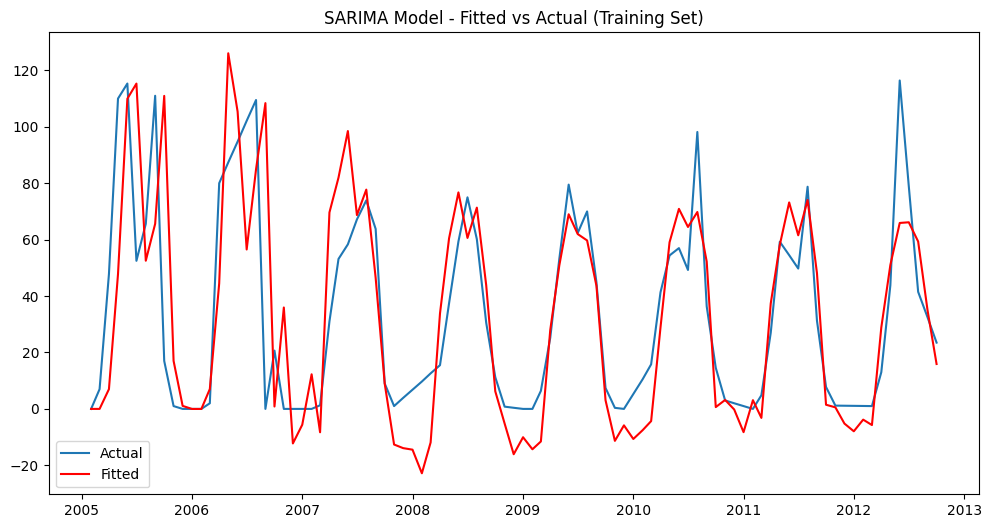

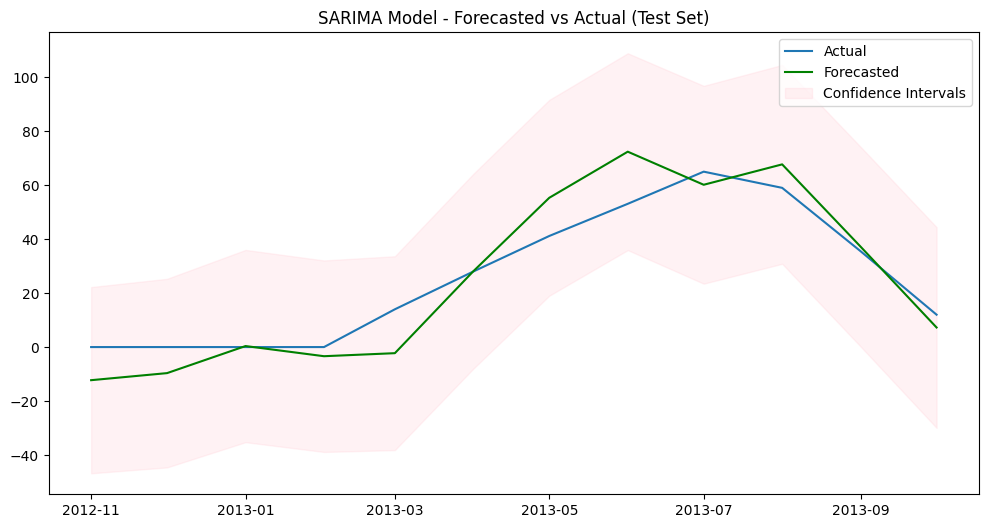

Mean Absolute Error: 7.96
Mean Squared Error: 101.50
Root Mean Squared Error: 10.07


In [133]:
# Definir el tamaño del conjunto de prueba
def showFinalPredictions(order, seasonal_order, data):
    test_size = 12  # Dos años de datos de prueba - 5% del dataset

    # Dividir los datos en conjuntos de entrenamiento y prueba
    train_data = data[:-test_size]
    test_data = data[-test_size:]

    # Crear y ajustar el modelo SARIMA en los datos de entrenamiento
    sarima_model = SARIMAX(train_data['count'], order=order, seasonal_order=seasonal_order)
    sarima_results = sarima_model.fit()

    # Graficar valores pronosticados vs reales para el conjunto de entrenamiento
    plt.figure(figsize=(12, 6))
    plt.plot(train_data['count'], label='Actual')
    plt.plot(sarima_results.fittedvalues, label='Fitted', color='red')
    plt.title('SARIMA Model - Fitted vs Actual (Training Set)')
    plt.legend()
    plt.show()

    # Pronóstico en el conjunto de prueba
    forecast = sarima_results.get_forecast(steps=test_size)

    # Extracción de valores reales del conjunto de prueba
    actual_values = test_data['count']

    # Extracción de valores pronosticados y intervalos de confianza
    forecasted_values = forecast.predicted_mean
    ci_lower = forecast.conf_int()['lower count']
    ci_upper = forecast.conf_int()['upper count']

    # Cálculo de métricas de evaluación
    mae = mean_absolute_error(actual_values, forecasted_values)
    mse = mean_squared_error(actual_values, forecasted_values)
    rmse = np.sqrt(mse)

    # Visualización del pronóstico con intervalos de confianza
    plt.figure(figsize=(12, 6))
    plt.plot(actual_values, label='Actual')
    plt.plot(forecasted_values, label='Forecasted', color='green')
    plt.fill_between(actual_values.index, ci_lower, ci_upper, color='pink', alpha=0.2, label='Confidence Intervals')
    plt.title('SARIMA Model - Forecasted vs Actual (Test Set)')
    plt.legend()
    plt.show()

    # Métricas de evaluación
    print(f'Mean Absolute Error: {mae:.2f}')
    print(f'Mean Squared Error: {mse:.2f}')
    print(f'Root Mean Squared Error: {rmse:.2f}')

showFinalPredictions(best_order, best_seasonal_order, datos_smoothed)

In [141]:
# Especificar la especie y localidad
loc_grouped_month_df = grouped_month_df[grouped_month_df['NombreLocalidad']==loc3]
top_birds = loc_grouped_month_df.groupby('NombreEspecie')['count'].sum().nlargest(5)
especie = top_birds.index[0]

/var/folders/dx/9xjdddhn30jfw1p92r0hl5gh0000gn/T/ipykernel_28748/1905538456.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['date'] = pd.to_datetime(grouped_month_df_mean[['year', 'month']].assign(DAY=1))


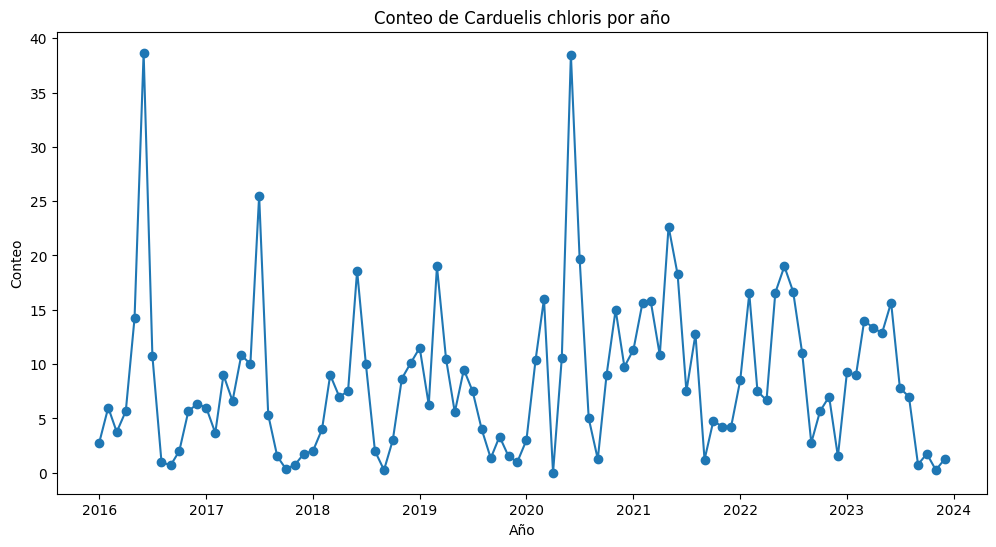

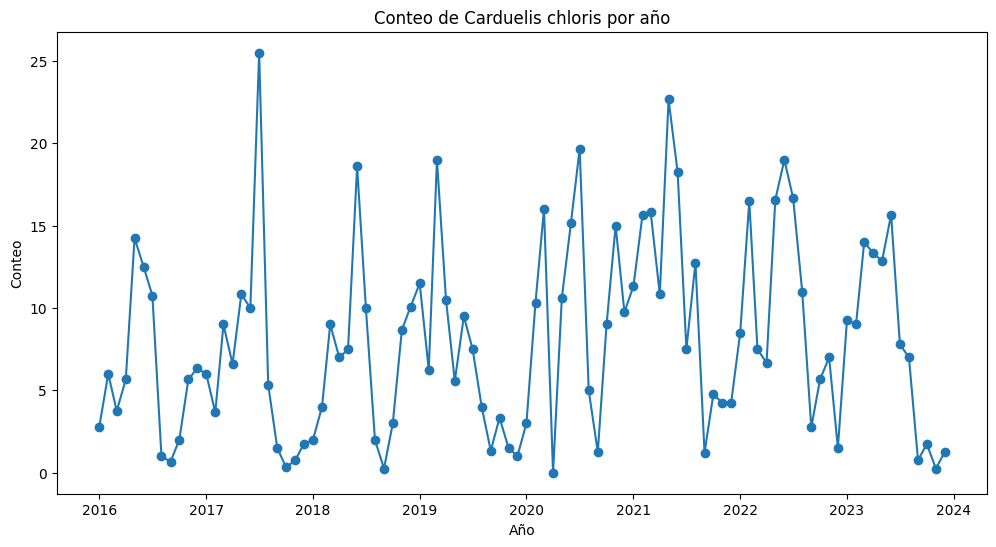

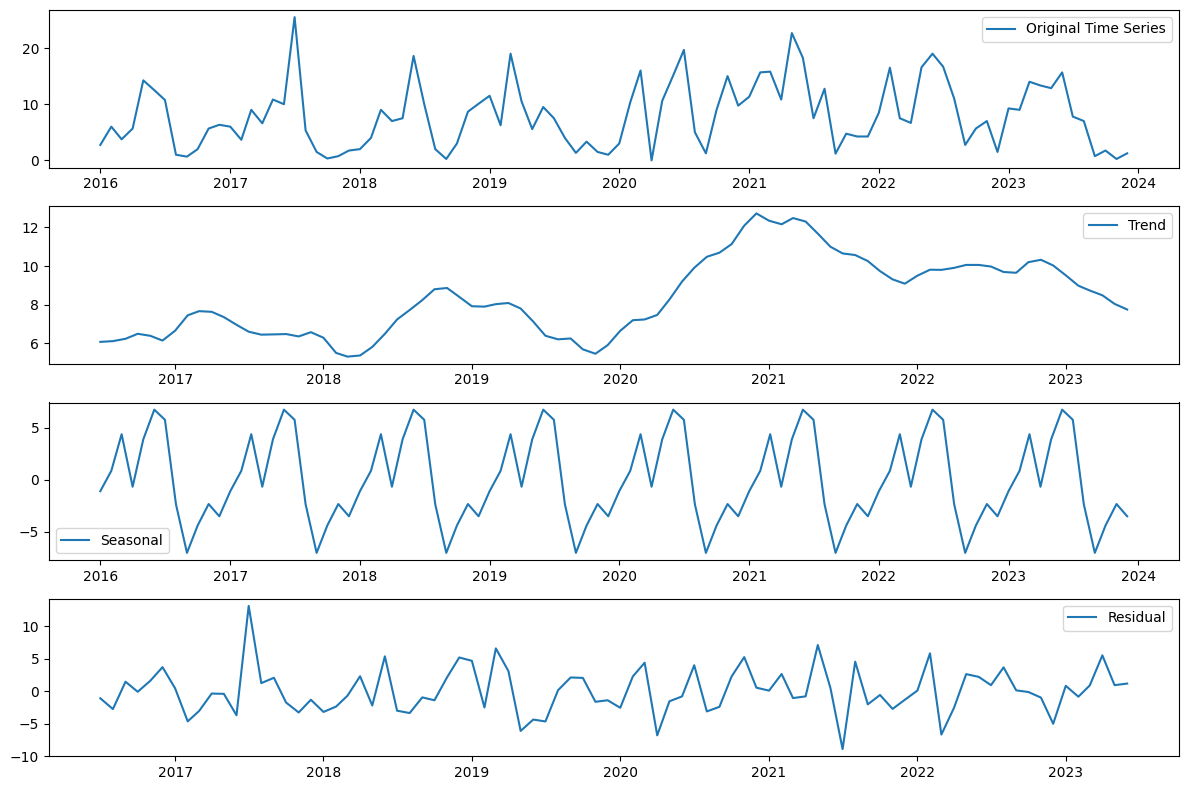

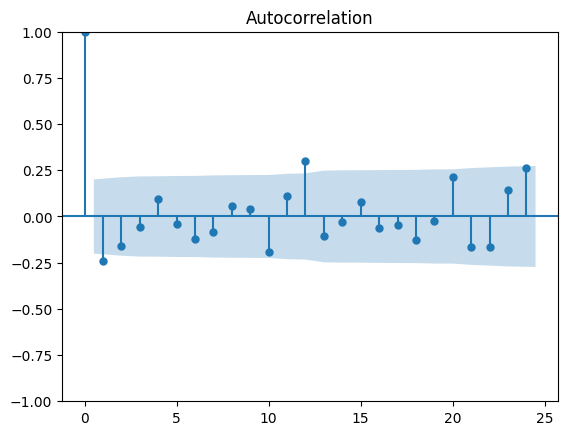

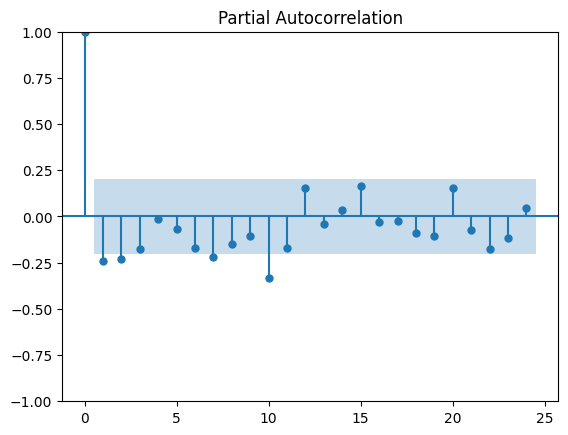

In [143]:
datos = defineSeries(especie, loc3, '2015-01-01', '2024-01-01')
plotCountOverTime(datos, especie)

datos_smoothed = datos.copy()
datos_smoothed['count'] = suavizar_outliers(datos['count'], 4)
plotCountOverTime(datos_smoothed, especie)

result = seasonal_decompose(datos_smoothed['count'], model='additive', period=12)
plotSeasonalDecomp(datos_smoothed, result)

diff = datos_smoothed['count'].diff().dropna()
plot_pacf(diff, lags=24)
plot_acf(diff, lags=24)
plt.show()

In [ ]:
p_values = [0, 10]
d_values = [0,1]
q_values = [0, 12]
P_values = [0, 10]
D_values = [1]
Q_values = [0, 12]
best_order, best_seasonal_order, best_aic = gridSearch(p_values, d_values, q_values, P_values, D_values, Q_values, datos_smoothed)

print(f"Best SARIMA Order: {best_order}")
print(f"Best SARIMA Seasonal Order: {best_seasonal_order}")
print(f"Best SARIMA AIC: {best_aic}")

showFinalPredictions(best_order, best_seasonal_order, datos_smoothed)